In [73]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import itertools
import sys, os
import cartopy
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

sys.path.insert(0, os.path.abspath(os.path.join(".")))
from virtualargofleet import Velocity, VirtualFleet, FloatConfiguration, VelocityField

In [74]:
ds = xr.open_dataset('/export/home/kbalem/Téléchargements/gigatl1_1h_tides_iberia_daily_2008-12-10.nc')
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (y_rho: 1260, x_rho: 1050, y_v: 1260, x_u: 1050, one: 1,
                 time: 1, sig_rho: 100, sig_w: 101)
Coordinates:
    lon_rho     (y_rho, x_rho) float64 11MB ...
    lat_rho     (y_rho, x_rho) float64 11MB ...
    lon_psi     (y_v, x_u) float64 11MB ...
    lat_psi     (y_v, x_u) float64 11MB ...
    lon_u       (y_rho, x_u) float64 11MB ...
    lat_u       (y_rho, x_u) float64 11MB ...
    lon_v       (y_v, x_rho) float64 11MB ...
    lat_v       (y_v, x_rho) float64 11MB ...
  * time        (time) datetime64[ns] 8B 2008-12-10
Dimensions without coordinates: y_rho, x_rho, y_v, x_u, one, sig_rho, sig_w
Data variables: (12/16)
    angle       (y_rho, x_rho) float64 11MB ...
    corio       (y_rho, x_rho) float64 11MB ...
    ex          (y_rho, x_rho) float64 11MB ...
    ey          (y_rho, x_rho) float64 11MB ...
    mask_rho    (y_rho, x_rho) float64 11MB ...
    xl          (one) float64 8B ...
    ...          ...
    u           (time, sig_rho, y_rho, x_u) float32 529MB ...
    v           (time, sig_rho, y_v, x_rho) float32 529MB ...
    ocean_time  (time) float32 4B ...
    bathy       (y_rho, x_rho) float64 11MB ...
    depth_rho   (time, sig_rho, y_rho, x_rho) float32 529MB ...
    depth_psiw  (time, sig_w, y_v, x_u) float32 534MB ...

In [75]:
ds['u'].values = np.zeros_like(ds['u'].values)+0
ds['v'].values = np.zeros_like(ds['v'].values)+1

In [76]:
ds.to_netcdf('sens_zonal_test3.nc')

In [77]:
files = 'sens_zonal_test3.nc'
variables = {'U': 'u', 'V': 'v', 'depth_rho':'depth_rho'}

dimensions = {'U': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
              'V': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
              'depth_rho' : {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'}              
             }

fieldset = FieldSet.from_c_grid_dataset(files,variables,dimensions,allow_time_extrapolation=True)

In [78]:
fieldset.U.set_depth_from_field(fieldset.depth_rho)
fieldset.V.set_depth_from_field(fieldset.depth_rho)

In [79]:
# I prefer add the bathy like that, then I'm sure that the bathy value is when there's no data (I'm not sure of that with the bathy var in the gigatl file)
df = xr.open_dataset(files) 
mask = df.isel(time=0)['depth_rho'].max(['sig_rho']) - 50
fieldset.add_field(Field('bathy',mask.values,lon=fieldset.U.lon,lat=fieldset.U.lat,interp_method='nearest'))

In [80]:
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1.)

inf

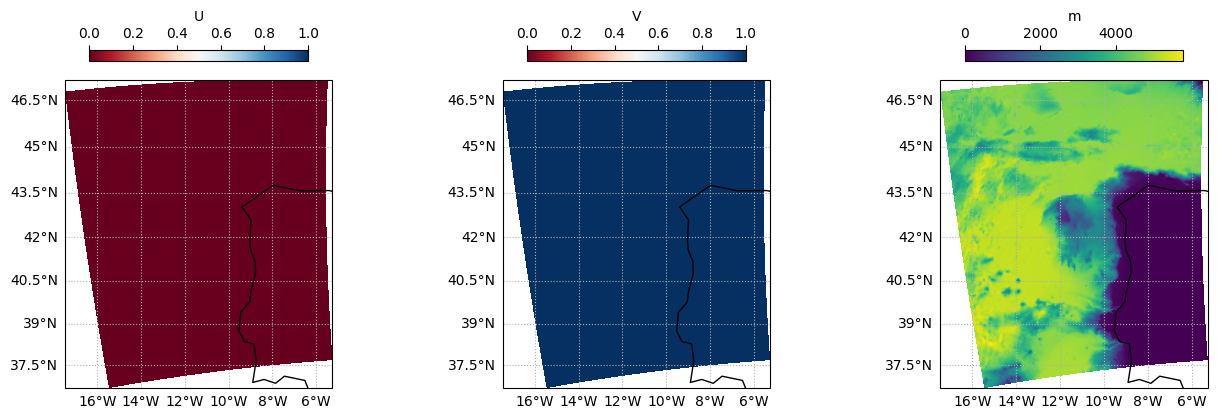

In [81]:
fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=0,vmax=1,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=0,vmax=1,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='V')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
plt.colorbar(a,location='top',shrink=0.6,label='m')

In [82]:
# Set min/max depth for float conf, this is to make sure Parcels doesn't struggle 
min_depth = 2.5 #np.ceil(ds['depth_rho'].max(['sig_rho']).min().values)
max_depth = 5800 #int(fieldset.gridset.grids[0].depth.max() / 100)*100
print(min_depth,max_depth)
fieldset.add_constant("vf_surface",min_depth)
fieldset.add_constant("vf_bottom", max_depth)

2.5 5800


In [83]:
# Define the deployment plan as a dictionary:
my_plan = {'lat': np.array([42., 43]), 
           'lon': np.array([-14, -14]), 
           'time': np.array([np.datetime64('2008-12-10'),np.datetime64('2008-12-10')]),
           'depth': np.array([min_depth, min_depth])}

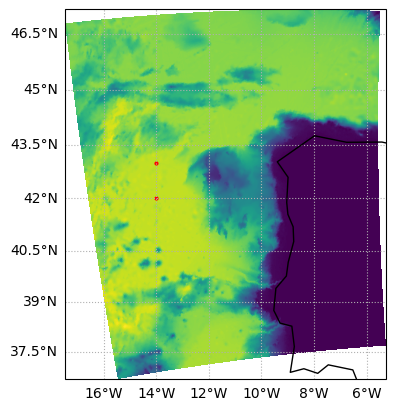

In [84]:
fig=plt.figure()
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 1, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
#b=ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1.plot(my_plan['lon'],my_plan['lat'],'r.',markersize=4,transform=pr1)

In [85]:
cfg = FloatConfiguration('default')
cfg.update('cycle_duration',24*10)
cfg.update('profile_depth',2000)
cfg.update('parking_depth',1000)
cfg

<FloatConfiguration><default>
- cycle_duration (Maximum length of float complete cycle): 240.0 [hours]
- life_expectancy (Maximum number of completed cycle): 200 [cycle]
- parking_depth (Drifting depth): 1000.0 [m]
- profile_depth (Maximum profile depth): 2000.0 [m]
- vertical_speed (Vertical profiling speed): 0.09 [m/s]

In [86]:
VFleet = VirtualFleet(plan=my_plan, fieldset=fieldset, mission=cfg, verbose_events=False)
VFleet

<VirtualFleet>
- 2 floats in the deployment plan
- No simulation performed

In [87]:
VFleet.simulate(
    duration=timedelta(days=1),
    step=timedelta(minutes=5),
    record=timedelta(minutes=5),
    output_folder=".",
)

INFO: Output files are stored in ./bvuo3_8c.zarr.
100%|██████████████████████████████████████████████████████████████████████████████████████| 86400.0/86400.0 [01:41<00:00, 850.07it/s]


<VirtualFleet>
- 2 floats in the deployment plan
- Number of simulation(s): 1
- Last simulation meta-data:
	- Duration: 01d 00h 00m 00s
	- Data recording every: 00h 05m
	- Trajectory file: ./bvuo3_8c.zarr
	- Execution time: 00d 00h 01m 44s
	- Executed on: minicotton

In [88]:
dout=xr.open_zarr('bvuo3_8c.zarr')
dout.load()

<xarray.Dataset> Size: 33kB
Dimensions:       (trajectory: 2, obs: 288)
Coordinates:
  * obs           (obs) int32 1kB 0 1 2 3 4 5 6 ... 281 282 283 284 285 286 287
  * trajectory    (trajectory) int64 16B 6 7
Data variables:
    cycle_age     (trajectory, obs) float32 2kB 300.0 600.0 ... 8.64e+04
    cycle_number  (trajectory, obs) float64 5kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cycle_phase   (trajectory, obs) float64 5kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    in_water      (trajectory, obs) float32 2kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lat           (trajectory, obs) float64 5kB 42.0 42.0 42.01 ... 43.77 43.77
    lon           (trajectory, obs) float64 5kB -14.0 -14.0 ... -14.11 -14.11
    time          (trajectory, obs) datetime64[ns] 5kB 2008-12-10 ... 2008-12...
    z             (trajectory, obs) float64 5kB 2.5 29.5 56.5 ... 1e+03 1e+03
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4KeepInWate...
    parcels_mesh:           spherical
    parcels_version:        3.0.2

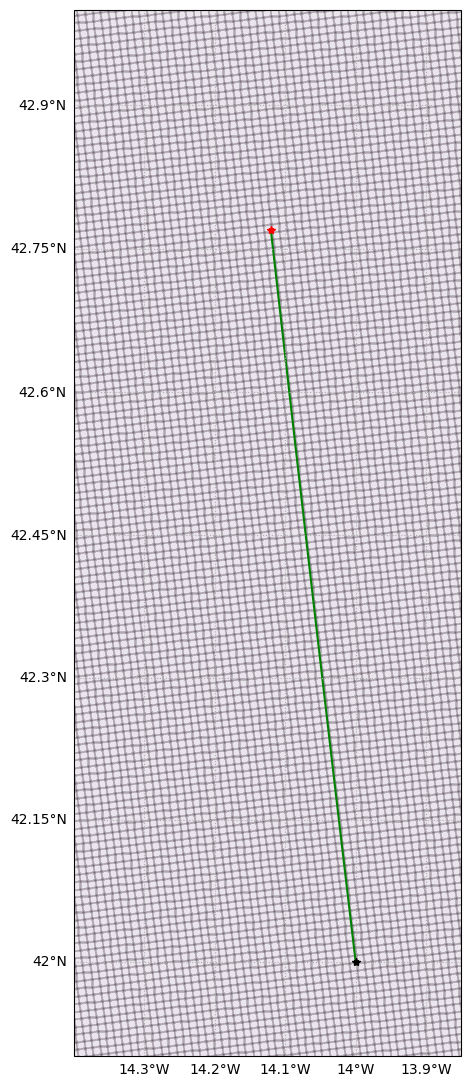

In [92]:
extent = [-14.4,-13.85,41.9,43]

fig=plt.figure(figsize=(5,16))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 1, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1]*0,shading='flat',transform=pr1,edgecolor='k',alpha=0.1)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
t=0
ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',transform=pr1,zorder=10)
ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'g',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',transform=pr1)

ax1.set_extent(extent)

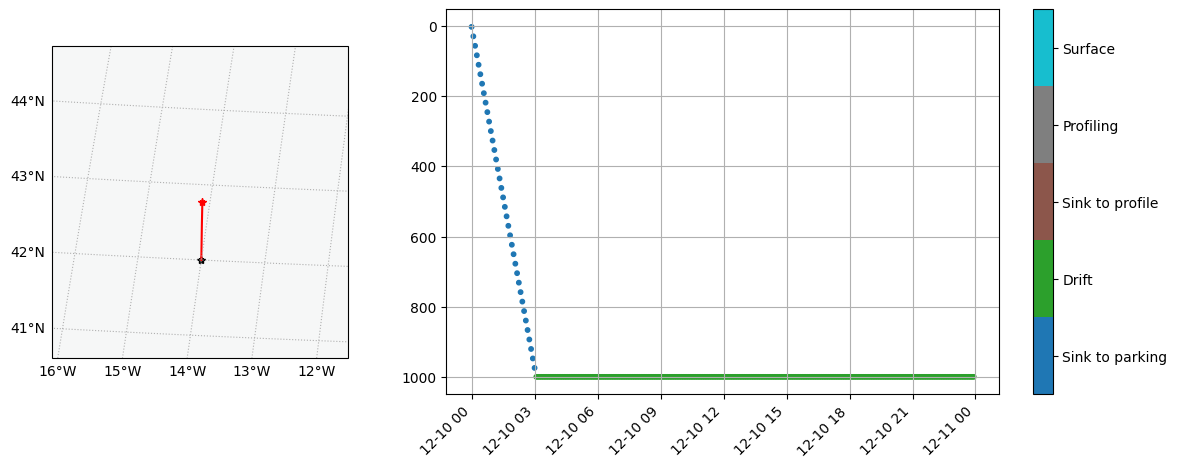

In [93]:
tr=0

fig=plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1,2,width_ratios=[.6,1.4])
pr1=ccrs.PlateCarree()
pr2=ccrs.LambertAzimuthalEqualArea()
ax1 = fig.add_subplot(gs[0], projection=pr2)
ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,49,:-1,:-1],shading='flat',transform=pr1,vmin=-0.7,vmax=0.7,cmap=plt.get_cmap('RdBu'))
#ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False

ax1.plot(dout['lon'].isel(trajectory=tr,obs=0),dout['lat'].isel(trajectory=tr,obs=0),'k*',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr),dout['lat'].isel(trajectory=tr),'r',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr,obs=-1),dout['lat'].isel(trajectory=tr,obs=-1),'r*',transform=pr1)
extent=[dout['lon'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lon'].isel(trajectory=tr,obs=-1).max().values +2,
        dout['lat'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lat'].isel(trajectory=tr,obs=-1).max().values +2]
ax1.set_extent(extent)

ax = fig.add_subplot(gs[1])
a=ax.scatter(dout['time'].isel(trajectory=tr),dout['z'].isel(trajectory=tr),s=10,c=dout['cycle_phase'].isel(trajectory=tr),cmap=plt.get_cmap('tab10',5),vmin=0,vmax=5)
ax.invert_yaxis()
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(':')
#ax.set_xlim([np.datetime64('2011-01-15'),np.datetime64('2011-01-16')])
cb=plt.colorbar(a,ticks=[0.5,1.5,2.5,3.5,4.5])
cb.set_ticklabels(['Sink to parking','Drift','Sink to profile','Profiling','Surface'])